In [1]:
%matplotlib inline
from StringProcessing import StringProcessing
from BuildVocabulary import BuildVocabulary as bv
from TransformerEncoder import TransformerEncoder
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from nltk.tokenize.toktok import ToktokTokenizer
from Visualization import Visualization
from gensim.models import Word2Vec
from Preprocess import Preprocess
from Utils import Utils
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import numpy as np

Using TensorFlow backend.


# Parameters

In [351]:
# Text parameters #
max_words = 50
test_path = "./tass-corpus/es/train.csv" # Dev

# Training Parameters #
path_model = "./best-models/transformer_1648NO.hdf5"
r_cats = {0:"N", 1:"NEU", 2:"NONE", 3:"P"}
tokenizer = ToktokTokenizer()
w2v_path = "./twitter87/twitter87.model"
w2v = Word2Vec.load(w2v_path)

# Encoder Parameters # # MEJOR
dropout_input = 0.7 #0.7
dropout_output = 0. # 0.
pe = False #False
embedding_dims = w2v.vector_size
n_encoders = 1 #2 #1
attention_dims = 64 #32 #64
n_heads = 8 #8
dim_h = 128 #256
final_h = False #False
pool_mode = "average" #"average"

output_encoder_dims = [embedding_dims for i in range(n_encoders)]
attention_dims = [attention_dims for i in range(n_encoders)]
n_heads = [n_heads for i in range(n_encoders)]

# Prepare inputs #

In [352]:
ids_dv, x_dv, y_dv = StringProcessing.load_samples(test_path)

# Preprocess #
x_dv = [Preprocess.preprocess(x, tokenizer) for x in x_dv]

# Represent #
rx_dv = np.array(StringProcessing.represent_documents(x_dv, max_words, embedding_dims, w2v, word_delimiter = " "))

# Masks #
masks_dv = np.array([((rx!=0).sum(axis=1)>0).astype("int") for rx in rx_dv])

# Positional Encodings #
matrix_pos_encodings = Utils.precompute_sent_pos_encodings(max_words, embedding_dims)
pe_dv = np.array([Utils.build_pe_sent_encodings(matrix_pos_encodings, m) for m in masks_dv])

# Load model

In [353]:
ht = TransformerEncoder(max_words = max_words,
                 embedding_dims = embedding_dims,
                 output_encoder_dims = output_encoder_dims,
                 attention_dims = attention_dims,
                 n_heads = n_heads,
                 dropout_input = dropout_input,
                 dropout_output = dropout_output,
                 pe = pe,
                 dim_h = dim_h,
                 final_h = final_h,
                 pool_mode = pool_mode)

ht.build()
print(ht.model.summary())
ht.compile(ht.model)
ht.load(ht.model, path_model)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 50, 300)      0                                            
__________________________________________________________________________________________________
my_masking_7 (MyMasking)        (None, 50, 300)      0           input_10[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_4 (SpatialDro (None, 50, 300)      0           my_masking_7[0][0]               
__________________________________________________________________________________________________
sentence_encoder_block_4 (Sente [(None, 50, 300), (N 795600      spatial_dropout1d_4[0][0]        
__________________________________________________________________________________________________
lambda_7 (

# Predict

In [354]:
preds = ht.model.predict([rx_dv, masks_dv, pe_dv], batch_size=256)
preds = [r_cats[p.argmax()] for p in preds]
truths = y_dv
print("Acc: %f" % accuracy_score(truths, preds))
print("MF1: %f" % f1_score(truths, preds, average="macro"))
print("MP: %f" % precision_score(truths, preds, average="macro"))
print("MR: %f" % recall_score(truths, preds, average="macro"))
print("Conf Matrix\n", confusion_matrix(truths, preds))
print("Classification Report\n", classification_report(truths, preds))

Acc: 0.798222
MF1: 0.769826
MP: 0.759095
MR: 0.786182
Conf Matrix
 [[391  45  17  21]
 [ 32  89   4  15]
 [  6   2 142   7]
 [ 29  31  18 276]]
Classification Report
               precision    recall  f1-score   support

           N       0.85      0.82      0.84       474
         NEU       0.53      0.64      0.58       140
        NONE       0.78      0.90      0.84       157
           P       0.87      0.78      0.82       354

   micro avg       0.80      0.80      0.80      1125
   macro avg       0.76      0.79      0.77      1125
weighted avg       0.81      0.80      0.80      1125



# Save Prediction Report

In [355]:
# Guarda un csv (texto, real, prediccion)
fw = open("results_report.csv", "w", encoding="utf8")
for i in range(len(preds)):
    fw.write(x_dv[i] + "\t" + truths[i] + "\t" + preds[i] + "\n")
fw.close()

# Get Attention Report

In [356]:
attns = ht.attn_model.predict([rx_dv, masks_dv, pe_dv], batch_size=256)

## Preds

In [357]:
# Palabra : {cabezal : {P:0, N:0, NEU:}}
word_attns = {}
counters = {}
for i in range(len(x_dv)):
    attns_i = attns[i]
    pred = preds[i]
    l_words = x_dv[i].split()
    pad = 0
    
    while len(l_words) < max_words:
        l_words.insert(0, "<pad>")
        pad += 1
    l_words = l_words[pad:]
    attns_i = attns_i[:, pad:, pad:]
    attns_i = attns_i.sum(axis=1)          
    ll_words = len(l_words)
    
    for j in range(ll_words):
        word = l_words[j]
        if word not in word_attns:
            word_attns[word] = {}
            counters[word] = {}
            
        for h in range(len(attns_i)):
            if h not in word_attns[word]:
                word_attns[word][h] = {"N":0., "NEU":0., "NONE":0., "P":0.}
                counters[word][h] = {"N":0., "NEU":0., "NONE":0., "P":0.}

            word_attns[word][h][pred] += (attns_i[h][j] / ll_words) # Normalizar por el nº de palabras a las que atiende
            counters[word][h][pred] += 1.

# Normalizar por el nº de muestras
for w in word_attns:
    for h in word_attns[w]:
        for c in word_attns[w][h]:
            word_attns[w][h][c] /= (counters[w][h][c] + 1e-16) #len(x_dv)      

In [358]:
word_attns["mierda"]

{0: {'N': 0.0641930145238127, 'NEU': 0.0, 'NONE': 0.0, 'P': 0.0},
 1: {'N': 0.5142942893618629, 'NEU': 0.0, 'NONE': 0.0, 'P': 0.0},
 2: {'N': 0.005693170015411896, 'NEU': 0.0, 'NONE': 0.0, 'P': 0.0},
 3: {'N': 0.7772578486487979, 'NEU': 0.0, 'NONE': 0.0, 'P': 0.0},
 4: {'N': 0.002285209576022767, 'NEU': 0.0, 'NONE': 0.0, 'P': 0.0},
 5: {'N': 0.11674678361291686, 'NEU': 0.0, 'NONE': 0.0, 'P': 0.0},
 6: {'N': 0.4203800996144613, 'NEU': 0.0, 'NONE': 0.0, 'P': 0.0},
 7: {'N': 0.003818231185340181, 'NEU': 0.0, 'NONE': 0.0, 'P': 0.0}}

## Truths

In [359]:
# Palabra : {cabezal : {P:0, N:0, NEU:}}
word_attns = {}
counters = {}
for i in range(len(x_dv)):
    attns_i = attns[i]
    pred = truths[i]
    l_words = x_dv[i].split()
    pad = 0
    
    while len(l_words) < max_words:
        l_words.insert(0, "<pad>")
        pad += 1
    l_words = l_words[pad:]
    attns_i = attns_i[:, pad:, pad:]
    attns_i = attns_i.sum(axis=1)          
    ll_words = len(l_words)
    
    for j in range(ll_words):
        word = l_words[j]
        if word not in word_attns:
            word_attns[word] = {}
            counters[word] = {}
            
        for h in range(len(attns_i)):
            if h not in word_attns[word]:
                word_attns[word][h] = {"N":0., "NEU":0., "NONE":0., "P":0.}
                counters[word][h] = {"N":0., "NEU":0., "NONE":0., "P":0.}

            word_attns[word][h][pred] += (attns_i[h][j] / ll_words) # Normalizar por el nº de palabras a las que atiende
            counters[word][h][pred] += 1.

# Normalizar por el nº de muestras
for w in word_attns:
    for h in word_attns[w]:
        for c in word_attns[w][h]:
            word_attns[w][h][c] /= (counters[w][h][c] + 1e-16) #len(x_dv) 

In [360]:
word_attns["mierda"]

{0: {'N': 0.0641930145238127, 'NEU': 0.0, 'NONE': 0.0, 'P': 0.0},
 1: {'N': 0.5142942893618629, 'NEU': 0.0, 'NONE': 0.0, 'P': 0.0},
 2: {'N': 0.005693170015411896, 'NEU': 0.0, 'NONE': 0.0, 'P': 0.0},
 3: {'N': 0.7772578486487979, 'NEU': 0.0, 'NONE': 0.0, 'P': 0.0},
 4: {'N': 0.002285209576022767, 'NEU': 0.0, 'NONE': 0.0, 'P': 0.0},
 5: {'N': 0.11674678361291686, 'NEU': 0.0, 'NONE': 0.0, 'P': 0.0},
 6: {'N': 0.4203800996144613, 'NEU': 0.0, 'NONE': 0.0, 'P': 0.0},
 7: {'N': 0.003818231185340181, 'NEU': 0.0, 'NONE': 0.0, 'P': 0.0}}

## All classes (creo que este es el análisis bueno, más que por cada clase)

In [361]:
# Palabra : {cabezal : }

word_attns = {}
counters = {}
for i in range(len(x_dv)):
    attns_i = attns[i]
    pred = truths[i]
    l_words = x_dv[i].split()
    pad = 0
    
    while len(l_words) < max_words:
        l_words.insert(0, "<pad>")
        pad += 1
    l_words = l_words[pad:]
    attns_i = attns_i[:, pad:, pad:]
    attns_i = attns_i.sum(axis=1)          
    ll_words = len(l_words)
    
    for j in range(ll_words):
        word = l_words[j]
        if word not in word_attns:
            word_attns[word] = {}
            counters[word] = {}
            
        for h in range(len(attns_i)):
            if h not in word_attns[word]:
                word_attns[word][h] = 0.
                counters[word][h] = 0.

            word_attns[word][h] += (attns_i[h][j] / ll_words) # Normalizar por el nº de palabras a las que atiende
            counters[word][h] += 1.

# Normalizar por el nº de muestras
for w in word_attns:
    for h in word_attns[w]:
        word_attns[w][h] /= (counters[w][h] + 1e-16) #len(x_dv) 

In [362]:
word_attns["mierda"]

{0: 0.0641930145238127,
 1: 0.5142942893618629,
 2: 0.005693170015411896,
 3: 0.7772578486487979,
 4: 0.002285209576022767,
 5: 0.11674678361291686,
 6: 0.4203800996144613,
 7: 0.003818231185340181}

In [363]:
word_attns["genial"]

{0: 0.015563593221086478,
 1: 0.38862860820412615,
 2: 0.6205552190616562,
 3: 0.053297064739706704,
 4: 0.918239009011053,
 5: 0.0852130642407086,
 6: 0.007947014442553805,
 7: 0.00038073882330150747}

In [364]:
word_attns["horrible"]

{0: 0.00021869257876747534,
 1: 0.10450488642642372,
 2: 3.9265119324370874e-07,
 3: 0.8286937412462736,
 4: 0.00010112562756005086,
 5: 0.25090912768715307,
 6: 0.013408326788952476,
 7: 0.0022496757538695085}

In [365]:
word_attns["maravilloso"]

{0: 7.981251988221393e-06,
 1: 0.8076121846318761,
 2: 0.7954747714693585,
 3: 0.3071372515066362,
 4: 0.948929572690273,
 5: 0.3581466739483898,
 6: 9.350472049331387e-05,
 7: 0.042206597035997016}

In [366]:
word_attns["peor"]

{0: 0.06091243339896137,
 1: 0.4666085839755733,
 2: 0.00011378889904308313,
 3: 0.8172337710779932,
 4: 0.007513131989782943,
 5: 0.8454424440865173,
 6: 0.5558768207887681,
 7: 0.0031165914805845536}

In [367]:
word_attns["amor"]

{0: 0.0002683526890947338,
 1: 0.5844093804192577,
 2: 0.2345553911233275,
 3: 0.0011864833286112611,
 4: 0.6156286451331922,
 5: 0.032815530019953125,
 6: 9.233125292887603e-08,
 7: 0.0004975195591626946}

In [368]:
word_attns["odio"]

{0: 0.05265140129392549,
 1: 0.89982311841346,
 2: 0.0017898519399225296,
 3: 0.9647921250270224,
 4: 0.1831041657811708,
 5: 0.8598009052071678,
 6: 0.007780205832533159,
 7: 0.004799559063283734}

Parece que el cabezal 3 reacciona mucho con palabras negativas y poco a las positivas; y el cabezal 4 justo al contrario

# Attns Visualization

In [369]:
n = 40
attns_i = attns[n]
l_words = x_dv[n].split()

pad = 0
while len(l_words) < max_words:
    l_words.insert(0, "<pad>")
    pad += 1
l_words = l_words[pad:]
attns_i = attns_i[:, pad:, pad:]
attns_h_3 = attns_i[3]
attns_h_4 = attns_i[4]

In [370]:
print(x_dv[n])

yo me cago en los muertos de todas las bacterias malignas de mi garganta .


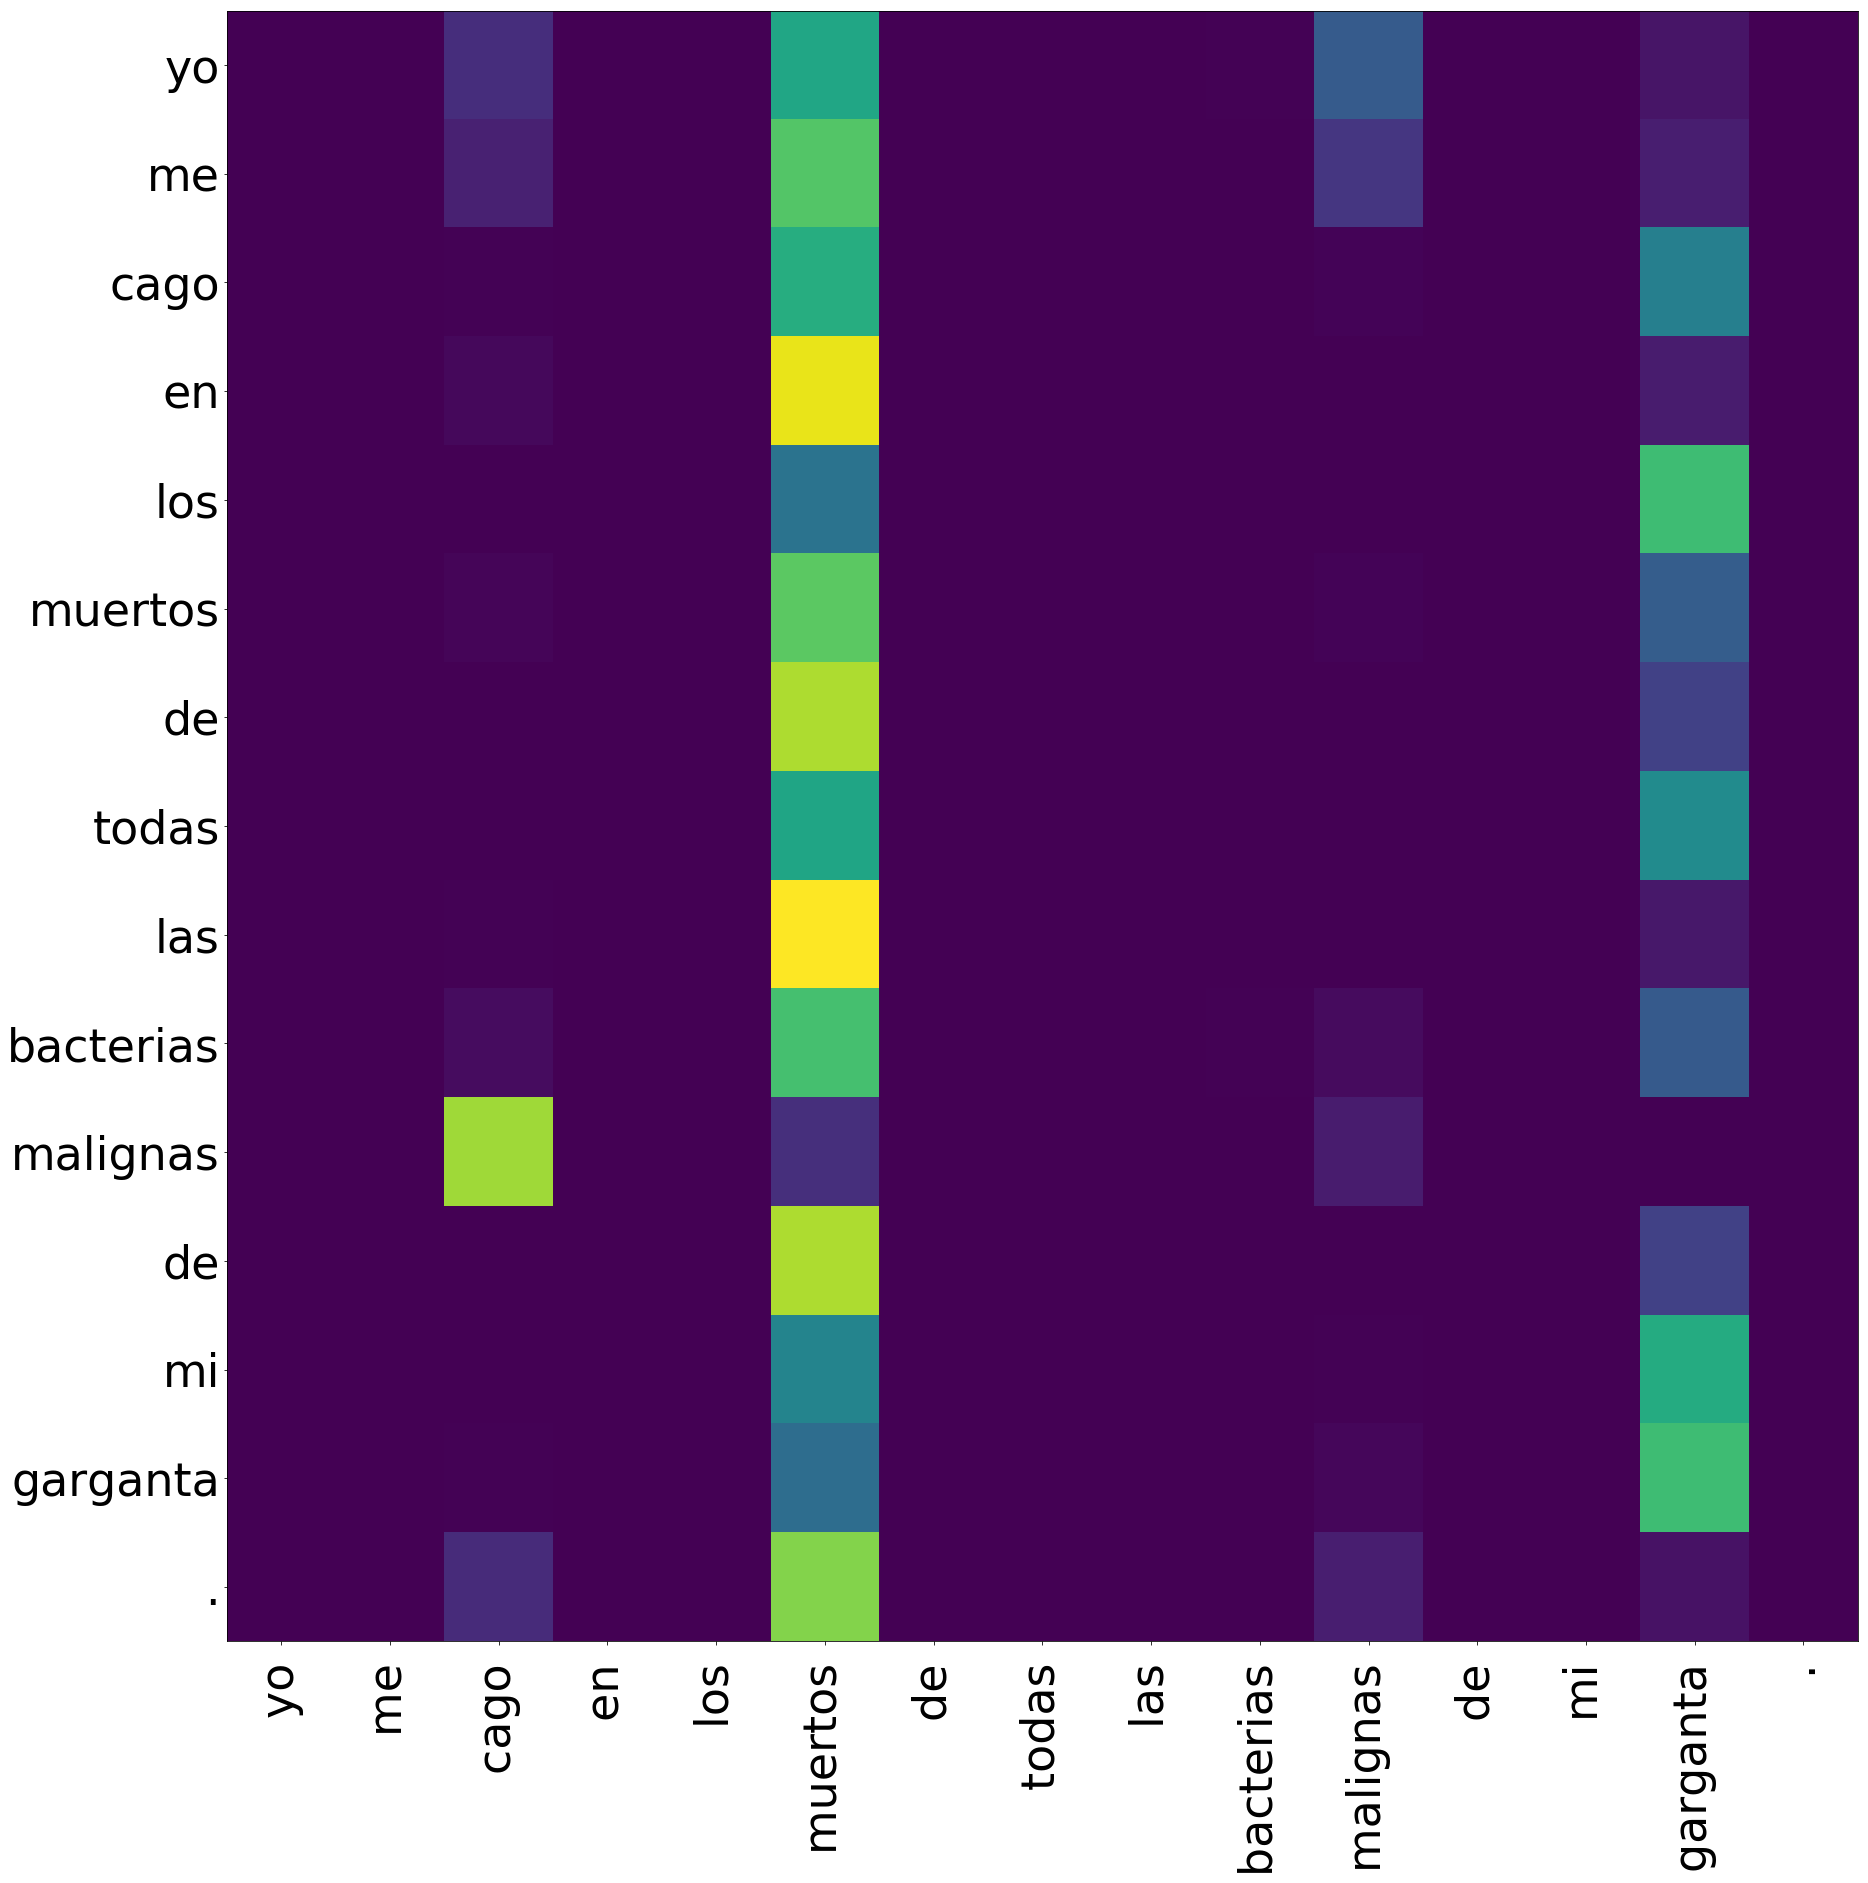

In [371]:
# Cabezal 3, parece captar negativos
Visualization.visualize_attentions(attns_h_3, 30, 30, rows=1, columns=1, ticks=l_words, output_file=None,
                                   save=False)

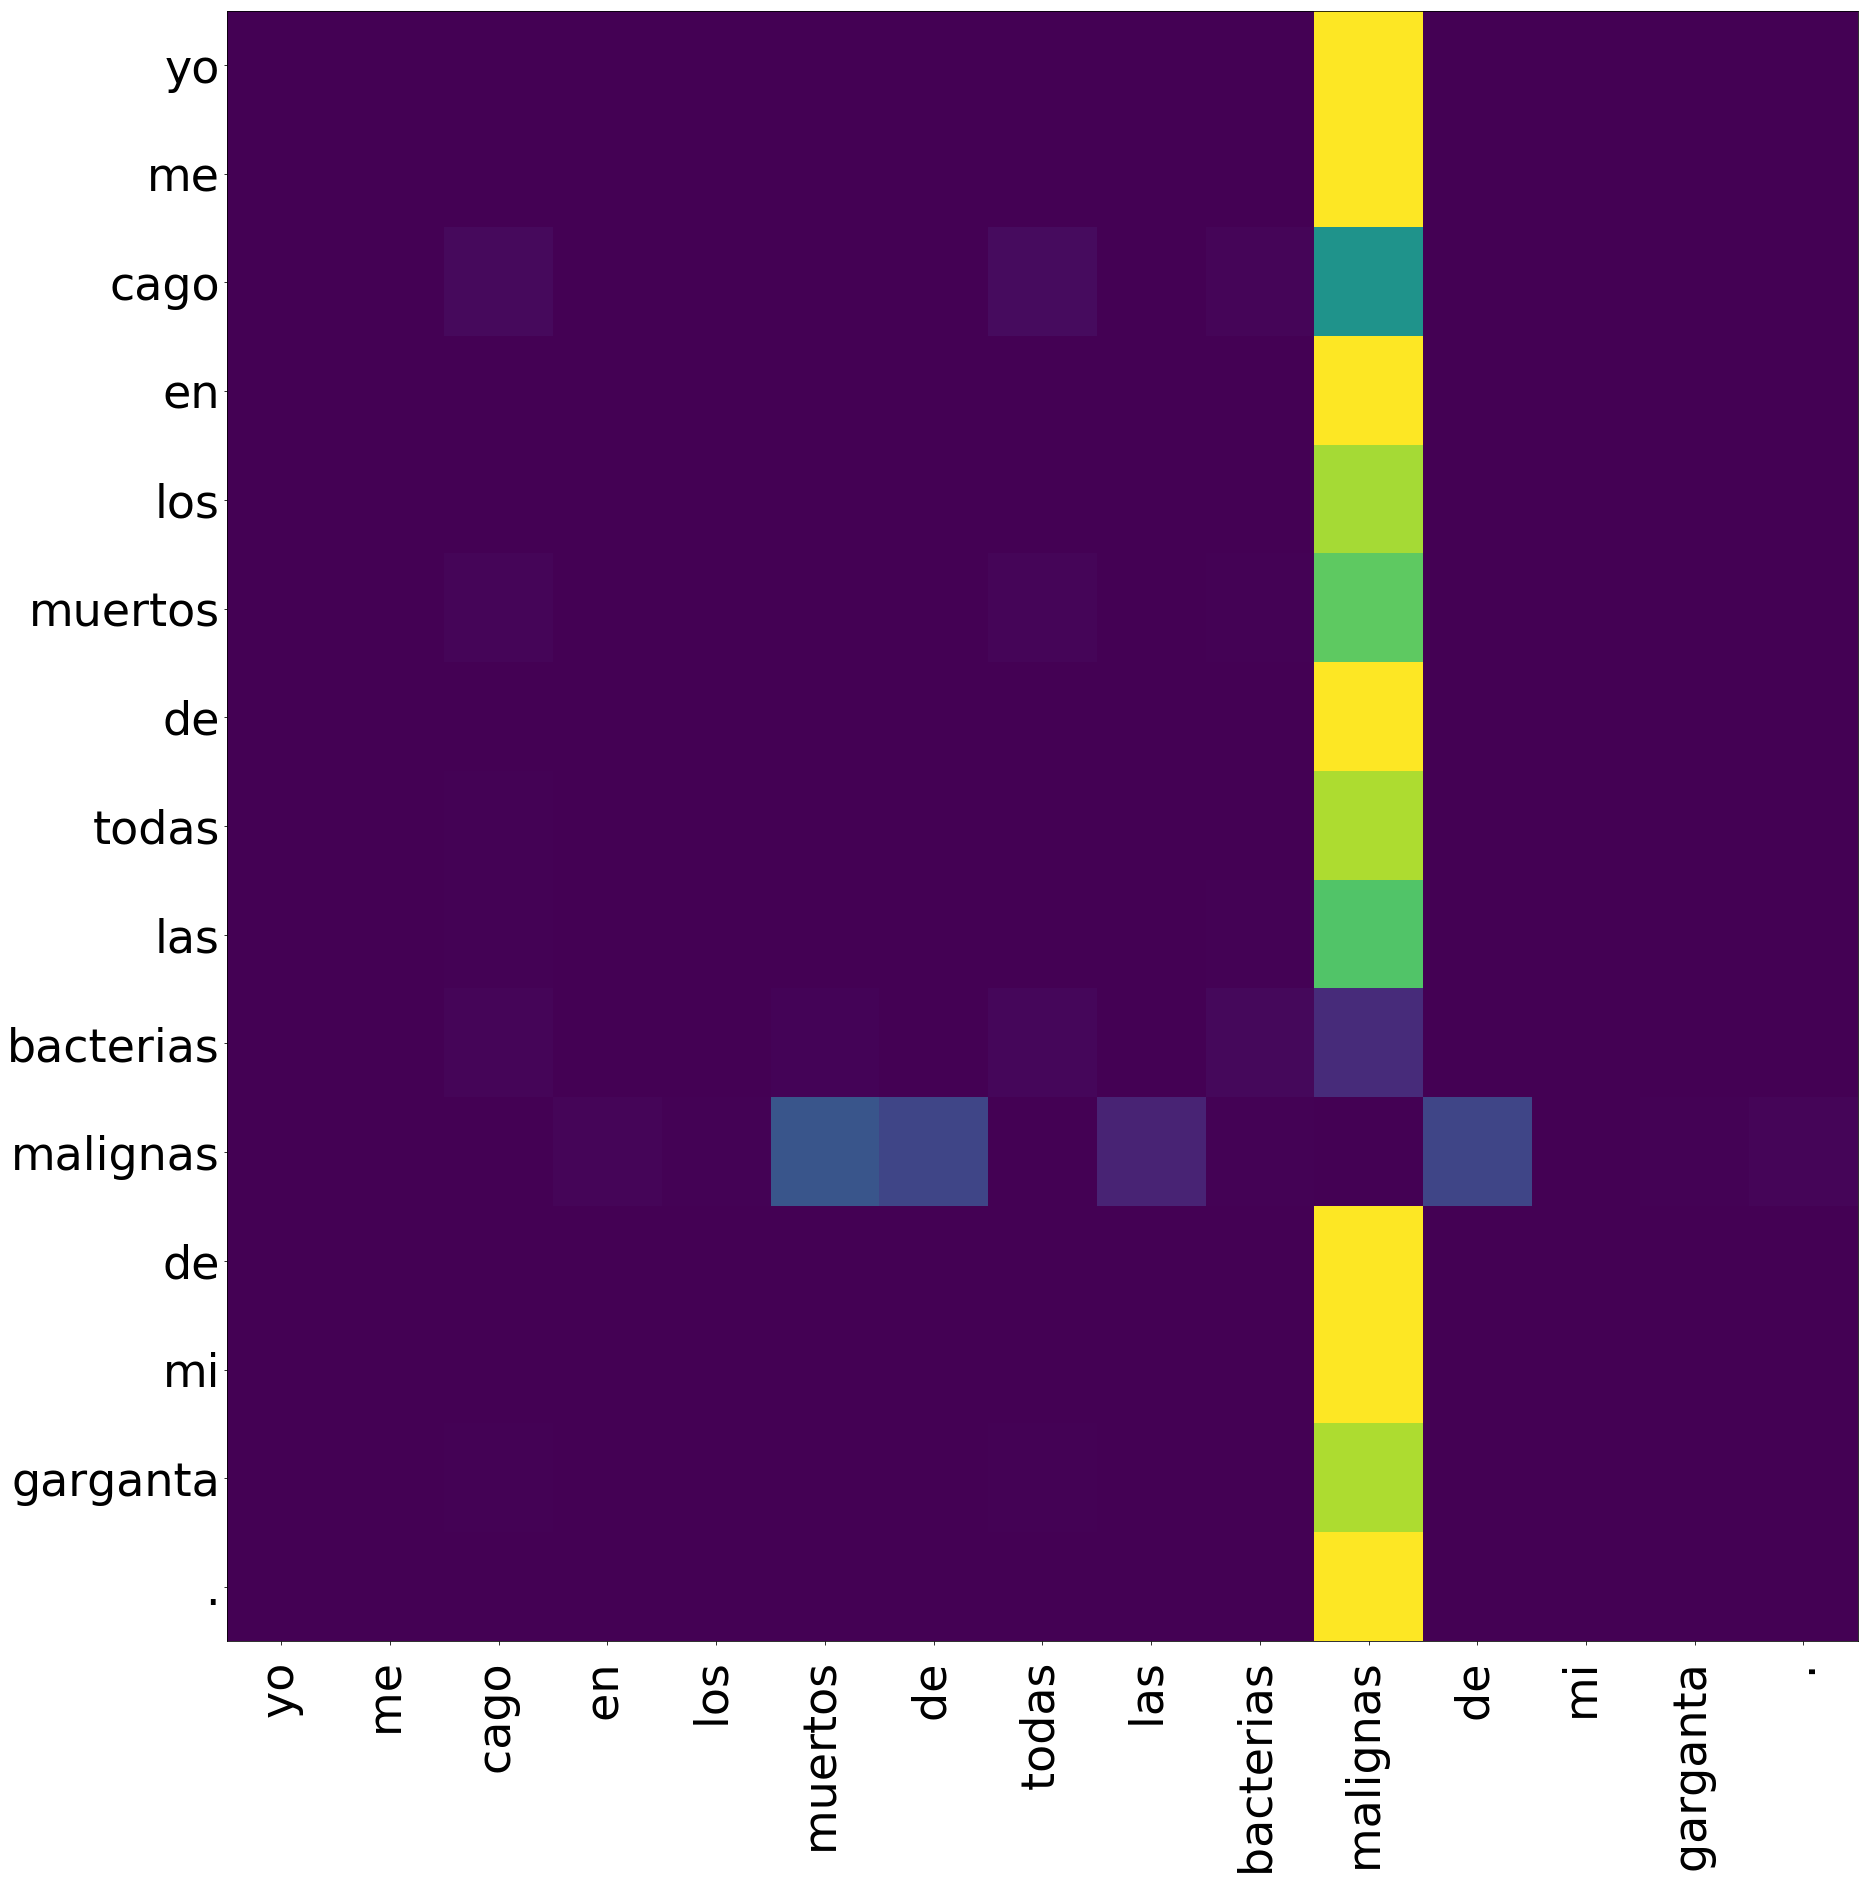

In [372]:
# Cabezal 4, parece captar positivos
Visualization.visualize_attentions(attns_h_4, 30, 30, rows=1, columns=1, ticks=l_words, output_file=None,
                                   save=False)

# Análisis con un lexicon

In [373]:
import unicodedata as uc

def remove_accents(sequence):
    return "".join([c for c in uc.normalize('NFD', sequence) if uc.category(c) != 'Mn'])

In [374]:
lex = open("./lexicons/elhuyar.txt", "r", encoding="utf8")
llex = []
for line in lex.readlines():
    s = line.strip().split("\t")
    if len(s)>1:
        word, tag = s[0], s[1]
        if "_" not in word and "-" not in word:
            word = remove_accents(word.replace("ñ", "ny"))
            llex.append((word, tag))
lex.close()

In [375]:
fw = open("attentions_elhuyar.out", "w", encoding="utf8")
for (word, tag) in llex:
    if word in word_attns:
        fw.write(word + "\n")
        for h in word_attns[word]:
            fw.write("Header %d: %.4f\n" % (h, word_attns[word][h]))
        fw.write("\n\n" + "-"*50 + "\n\n")
fw.close()

### Buscar los cabezales que maximizan su valor de atención sobre un lexicon supervisado en español (Elhuyar de ejemplo) #

In [376]:
positive_words = [word for (word, tag) in llex if tag == "positive"]
negative_words = [word for (word, tag) in llex if tag == "negative"]

In [377]:
sum_attns_positive = np.array([0. for i in range(len(word_attns["de"]))])
counts = 0.

for word in positive_words:
    if word in word_attns:
        w_attns = word_attns[word]
        h_attns = np.array([word_attns[word][h] for h in word_attns[word]])
        sum_attns_positive += h_attns
        counts += 1.
        
sum_attns_positive /= counts

In [378]:
sum_attns_positive

array([0.03588781, 0.19682402, 0.24214632, 0.1222656 , 0.27620932,
       0.09831521, 0.07431453, 0.02675657])

In [379]:
print("Best header positive: %d" % sum_attns_positive.argmax())

Best header positive: 4


In [380]:
sum_attns_negative = np.array([0. for i in range(len(word_attns["de"]))])
counts = 0.

for word in negative_words:
    if word in word_attns:
        w_attns = word_attns[word]
        h_attns = np.array([word_attns[word][h] for h in word_attns[word]])
        sum_attns_negative += h_attns
        counts += 1.
        
sum_attns_negative /= counts

In [381]:
sum_attns_negative

array([0.06401296, 0.16549543, 0.15630745, 0.420905  , 0.0435324 ,
       0.292466  , 0.16695802, 0.03111334])

In [382]:
print("Best header negative: %d" % sum_attns_negative.argmax())

Best header negative: 3


### Clasificar el lexicon usando los cabezales 3 y 4 (75% Acc)

In [383]:
n_errors = 0.
n_words = 0.

for (word, tag) in llex:
    if word in word_attns:
        heads = word_attns[word]
        if heads[3] > heads[4]:
            pred = "negative"
        else:
            pred = "positive"
        
        if pred != tag:
            n_errors += 1
            
        n_words += 1.
        
print("Acc: %.4f%%" % ((1. - ((n_errors / n_words))) * 100))

Acc: 72.3127%


# Buscar cabezales que encuentren la negación

In [384]:
word_attns["no"]

{0: 0.5862150068564929,
 1: 0.1115538347181979,
 2: 0.03182720329866512,
 3: 3.8870710803736697e-05,
 4: 0.0008983049280324647,
 5: 0.00043905286197693167,
 6: 0.33562008160401746,
 7: 0.05715296737549685}

In [385]:
word_attns["ni"]

{0: 0.042637915283393245,
 1: 0.0007632901139980088,
 2: 0.0001109618878351867,
 3: 2.042149359226152e-05,
 4: 0.00012774999011417207,
 5: 0.00018677316385010666,
 6: 0.11917865274567499,
 7: 0.09093342260860507}

In [386]:
word_attns["nunca"]

{0: 0.6021199534968926,
 1: 0.2865308556424445,
 2: 0.07173275479766755,
 3: 7.13049234563195e-05,
 4: 0.00022505090735440255,
 5: 0.0826556985228488,
 6: 0.12988290893884272,
 7: 0.22615047167882263}

In [387]:
word_attns["nada"]

{0: 0.2940266061174666,
 1: 0.1007998243628293,
 2: 0.08725988318794962,
 3: 8.471598091290169e-05,
 4: 0.00011659768452576185,
 5: 0.0010361335040543801,
 6: 0.05574300928940526,
 7: 0.17345328882340352}

In [388]:
word_attns["nadie"]

{0: 0.18370533708965517,
 1: 0.0024565690765691955,
 2: 0.006173396305728012,
 3: 0.00015874200649223927,
 4: 9.315072828310051e-05,
 5: 6.407740946314541e-05,
 6: 0.11605773287743675,
 7: 0.0001867578636300786}

In [389]:
word_attns["ningun"]

{0: 0.017423178553581237,
 1: 0.00013880841201171278,
 2: 0.15787865012884142,
 3: 0.008636540625593625,
 4: 0.00012660500593483448,
 5: 0.00010756368516013026,
 6: 0.00914898255839944,
 7: 0.0028390205275536573}

In [390]:
word_attns["ninguna"]

{0: 0.18427165916987828,
 1: 3.343356365803629e-05,
 2: 2.0733980120114992e-08,
 3: 1.5650769975244267e-07,
 4: 0.0003996189750198807,
 5: 6.28324892115728e-11,
 6: 0.00993659027985164,
 7: 8.97447195922853e-12}

In [391]:
word_attns["tampoco"]

{0: 0.20229454613960116,
 1: 0.06099839990256197,
 2: 5.4078217508439035e-05,
 3: 0.0002569961431025295,
 4: 6.516424243697817e-05,
 5: 0.00023799345014433924,
 6: 0.31043479925126327,
 7: 0.04887507141735943}

In [392]:
word_attns["ninguno"]

{0: 0.37197374696305346,
 1: 1.3586383415208225e-05,
 2: 0.01637829358459008,
 3: 0.00020401489832117575,
 4: 0.0006424439139076217,
 5: 1.313526424355311e-05,
 6: 0.13700208034404,
 7: 0.0023428636185346035}

El cabezal 0 parece reaccionar a la negación